<a href="https://colab.research.google.com/github/moodychinsaki/MLprojectt/blob/main/ModelCV5fold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ModelCV-5fold

In [1]:
import os
from os import listdir, makedirs
from os.path import isfile, join
import pandas as pd
from PIL import Image
import glob
from pathlib import Path
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.optimizers import SGD, RMSprop
import cv2
from os.path import isfile,join, exists
import zipfile
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import statistics as st
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Activation
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
import gc





In [2]:
pip uninstall keras-preprocessing -y

In [3]:
pip install -q -U git+https://github.com/keras-team/keras-preprocessing.git

  Preparing metadata (setup.py) ... done


In [4]:
pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.4 MB/s eta 0:00:00


In [5]:
import keras_tuner as kt

## Get the data from cloud

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/CatsDogs.zip', 'r') # Open the zip file containing all the images
zip_ref.extractall('/tmp') # Extract the file in /tmp folder
zip_ref.close()

## Removing corrupted images

In [8]:
# Assignment of paths
cat_path = glob.glob("./../tmp/CatsDogs/Cats/*.jpg")
dog_path = glob.glob("./../tmp/CatsDogs/Dogs/*.jpg")
paths = list([cat_path, dog_path])

In [9]:
#  generic code for removing corrupted images
num_skipped = 0
total = 0
for path in paths:
  for filename in path:
    if os.path.exists(filename):
      try:
        total += 1
        with open(filename, "rb") as fobj:
          is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
      except IOError:
        pass
      if not is_jfif:
        num_skipped += 1
        # Deleting corrupted image
        os.remove(filename)
 



**Concatanete data frames **
not stratifying this time

In [10]:
df_cat = pd.DataFrame({"img_name": [f"/tmp/CatsDogs/Cats/{i}" for i in os.listdir('/tmp/CatsDogs/Cats')]})
df_cat["label"] = "cat"
df_dog = pd.DataFrame({"img_name": [f"/tmp/CatsDogs/Dogs/{i}" for i in os.listdir('/tmp/CatsDogs/Dogs')]})
df_dog["label"] = "dog"
mixedF = pd.concat([df_cat, df_dog], ignore_index=True)
mixedF = mixedF.sample(frac=1, random_state = 789).reset_index(drop=True) # shuffles and drops old index, shuffle is reproducable

In [11]:
# Splits as training set and test set
trainPlusval_df, test_df = train_test_split(mixedF, test_size=0.2, random_state = 789)
     

# Splits training set into training and validation set (15% validation)
train_df, val_df = train_test_split(trainPlusval_df, test_size=0.15, random_state = 789)

Data generators to prevent ram crashes on **Colab** free plan

In [12]:
image_size = (160,160,3) # increased to 160x160 for model2hypt

In [13]:
# Data Generators for normalising images
imag_gen = ImageDataGenerator(rescale=1/255) 

In [14]:
# flow_from_dataframe method of ImageDataGenerator creates data generators for training, validation, and testing
trainPlusvalid_gen = imag_gen.flow_from_dataframe(dataframe=trainPlusval_df, 
                                                            directory=None, x_col="img_name",
                                                            y_col="label",
                                                            batch_size=90, seed=789, #batch size 90 for model2hypt
                                                            shuffle=True, class_mode="binary", 
                                                            target_size=image_size[0:2]) # img size decreased to 160x160

test_gen = imag_gen.flow_from_dataframe(dataframe = test_df, directory=None,
                                                          x_col="img_name", y_col="label",
                                                          batch_size=90, 
                                                          seed=789, shuffle=True, class_mode="binary",
                                                          target_size=image_size[0:2])

train_gen = imag_gen.flow_from_dataframe(dataframe=train_df, 
                                                            directory=None, x_col="img_name",
                                                            y_col="label",
                                                            batch_size=90, seed=789,
                                                            shuffle=True, class_mode="binary", 
                                                            target_size=image_size[0:2])

valid_gen = imag_gen.flow_from_dataframe(dataframe= val_df, 
                                                            directory=None, x_col="img_name",
                                                            y_col="label",
                                                            batch_size=90, seed=789,
                                                            shuffle=True, class_mode="binary", # 0 or 1 labels cats or dog
                                                            target_size=image_size[0:2])

Found 18728 validated image filenames belonging to 2 classes.
Found 4682 validated image filenames belonging to 2 classes.
Found 15918 validated image filenames belonging to 2 classes.
Found 2810 validated image filenames belonging to 2 classes.


Model CV (5-fold) 

In [18]:
import scipy as scipy
from multiprocessing import Queue
import sklearn
import pandas as pd
import numpy as np
import datetime
from PIL import Image # to open images
import os
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import shutil


In [19]:
from sklearn.model_selection import KFold, train_test_split
import pickle

train_df, valid_df = train_test_split(train_df, 
                                   test_size = 0.12, 
                                   random_state = 789)

folds = KFold(n_splits=5, shuffle = True, random_state = 789)

In [31]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation
from tensorflow.keras.layers.experimental.preprocessing import RandomZoom
from tensorflow.keras.layers import Dropout
modelCV = Sequential(name="MODEL_CV")
#Data Augmentation
modelCV.add(RandomFlip('horizontal'))
modelCV.add(RandomRotation(0.15))
modelCV.add(RandomZoom(0.15))
# add padding to the first Conv2D layer
modelCV.add(Conv2D(32, (3, 3), strides=(2, 2) ,input_shape=image_size, padding='valid'))  
modelCV.add(Activation('relu'))
modelCV.add(MaxPooling2D(pool_size=(2, 2))) 

modelCV.add(Conv2D(128, (3, 3), strides=(2, 2), padding='valid' ))
modelCV.add(Activation('relu'))
modelCV.add(MaxPooling2D(pool_size=(2, 2)))
# added hidden layer model2hypt
modelCV.add(Conv2D(256, (3, 3), strides=(2, 2), padding='valid'))
modelCV.add(Activation('relu'))
modelCV.add(MaxPooling2D(pool_size=(2, 2)))
#Dropout
modelCV.add(Dropout(0.25))

modelCV.add(Flatten())  
modelCV.add(Dense(32))
#Dropout
modelCV.add(Dropout(0.30))

modelCV.add(Dense(1))
modelCV.add(Activation('sigmoid'))



In [35]:
model_cv=modelCV

In [36]:
model_cv_checkpoint = ModelCheckpoint("Model_CV", monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")


In [43]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 789)
kfVal = KFold(n_splits = 5, shuffle = True, random_state = 789)

# loop for mixed df of cats and dogs 
for val_train_index, test_index in kf.split(mixedF):
    # Splitted before as training set and test set --- trainPlusval and test set
    val_train, df_test = mixedF.iloc[val_train_index], mixedF.iloc[test_index]
    
    train, validation = next(kfVal.split(val_train))
    
    # Splitted before training set into training and validation set (15% validation)
    df_train, df_validation = val_train.iloc[train], val_train.iloc[validation]
   

    # GENERATORS
    train_data_generator = imag_gen.flow_from_dataframe(df_train, 
                                                   directory = None,
                                                   x_col = "img_name", 
                                                   y_col = "label",
                                                   class_mode = "binary", 
                                                   shuffle = True,
                                                   seed = 789,
                                                   target_size=image_size[0:2], 
                                                   batch_size = 90),
    
    valid_data_generator  = imag_gen.flow_from_dataframe(df_validation, 
                                                    directory = None, 
                                                    x_col = "img_name",
                                                    y_col = "label",
                                                    class_mode = "binary", 
                                                    shuffle = True,
                                                    seed = 789,
                                                    target_size=image_size[0:2], # img size decreased to 160x160
                                                    batch_size = 90),
    
    test_data_generator = imag_gen.flow_from_dataframe(df_test, 
                                                  directory = None, 
                                                  seed = 789,
                                                  x_col = "img_name",
                                                  y_col = "label",
                                                  class_mode = "binary", 
                                                  shuffle = True, 
                                                  target_size=image_size[0:2], # img size decreased to 160x160)
                                                  batch_size = 90),

Found 14982 validated image filenames belonging to 2 classes.
Found 3746 validated image filenames belonging to 2 classes.
Found 4682 validated image filenames belonging to 2 classes.
Found 14982 validated image filenames belonging to 2 classes.
Found 3746 validated image filenames belonging to 2 classes.
Found 4682 validated image filenames belonging to 2 classes.
Found 14982 validated image filenames belonging to 2 classes.
Found 3746 validated image filenames belonging to 2 classes.
Found 4682 validated image filenames belonging to 2 classes.
Found 14982 validated image filenames belonging to 2 classes.
Found 3746 validated image filenames belonging to 2 classes.
Found 4682 validated image filenames belonging to 2 classes.
Found 14982 validated image filenames belonging to 2 classes.
Found 3746 validated image filenames belonging to 2 classes.
Found 4682 validated image filenames belonging to 2 classes.


In [47]:
# Compile the model
model_cv.compile(loss='binary_crossentropy',
                   optimizer="adam",
                    metrics=['accuracy'])


In [52]:
#  FIT the modelCV
fitCV =  model_cv.fit(train_gen,
                    validation_data = valid_gen,
                    steps_per_epoch = train_gen.n//train_gen.batch_size,
                    validation_steps = valid_gen.n//valid_gen.batch_size,
                    epochs = 20,
                    callbacks = [model_cv_checkpoint])

Epoch 1/20
176/176 [==============================] - ETA: 0s - loss: 0.6751 - accuracy: 0.5701
Epoch 1: val_accuracy improved from -inf to 0.61577, saving model to Model_CV


176/176 [==============================] - 75s 391ms/step - loss: 0.6751 - accuracy: 0.5701 - val_loss: 0.6425 - val_accuracy: 0.6158
Epoch 2/20
176/176 [==============================] - ETA: 0s - loss: 0.6101 - accuracy: 0.6643
Epoch 2: val_accuracy improved from 0.61577 to 0.69570, saving model to Model_CV


176/176 [==============================] - 74s 420ms/step - loss: 0.6101 - accuracy: 0.6643 - val_loss: 0.5719 - val_accuracy: 0.6957
Epoch 3/20
176/176 [==============================] - ETA: 0s - loss: 0.5688 - accuracy: 0.7049
Epoch 3: val_accuracy improved from 0.69570 to 0.74946, saving model to Model_CV


176/176 [==============================] - 70s 399ms/step - loss: 0.5688 - accuracy: 0.7049 - val_loss: 0.5269 - val_accuracy: 0.7495
Epoch 4/20
176/176 [==============================] - ETA: 0s - loss: 0.5362 - accuracy: 0.7324
Epoch 4: val_accuracy improved from 0.74946 to 0.77097, saving model to Model_CV


176/176 [==============================] - 99s 561ms/step - loss: 0.5362 - accuracy: 0.7324 - val_loss: 0.4917 - val_accuracy: 0.7710
Epoch 5/20
176/176 [==============================] - ETA: 0s - loss: 0.5147 - accuracy: 0.7466
Epoch 5: val_accuracy did not improve from 0.77097
176/176 [==============================] - 69s 390ms/step - loss: 0.5147 - accuracy: 0.7466 - val_loss: 0.4816 - val_accuracy: 0.7703
Epoch 6/20
176/176 [==============================] - ETA: 0s - loss: 0.5055 - accuracy: 0.7506
Epoch 6: val_accuracy improved from 0.77097 to 0.77563, saving model to Model_CV


176/176 [==============================] - 68s 387ms/step - loss: 0.5055 - accuracy: 0.7506 - val_loss: 0.4728 - val_accuracy: 0.7756
Epoch 7/20
176/176 [==============================] - ETA: 0s - loss: 0.4847 - accuracy: 0.7685
Epoch 7: val_accuracy improved from 0.77563 to 0.78961, saving model to Model_CV


176/176 [==============================] - 69s 392ms/step - loss: 0.4847 - accuracy: 0.7685 - val_loss: 0.4475 - val_accuracy: 0.7896
Epoch 8/20
176/176 [==============================] - ETA: 0s - loss: 0.4720 - accuracy: 0.7765
Epoch 8: val_accuracy did not improve from 0.78961
176/176 [==============================] - 67s 383ms/step - loss: 0.4720 - accuracy: 0.7765 - val_loss: 0.4628 - val_accuracy: 0.7842
Epoch 9/20
176/176 [==============================] - ETA: 0s - loss: 0.4649 - accuracy: 0.7820
Epoch 9: val_accuracy improved from 0.78961 to 0.79355, saving model to Model_CV


176/176 [==============================] - 68s 387ms/step - loss: 0.4649 - accuracy: 0.7820 - val_loss: 0.4452 - val_accuracy: 0.7935
Epoch 10/20
176/176 [==============================] - ETA: 0s - loss: 0.4491 - accuracy: 0.7908
Epoch 10: val_accuracy improved from 0.79355 to 0.81075, saving model to Model_CV


176/176 [==============================] - 72s 408ms/step - loss: 0.4491 - accuracy: 0.7908 - val_loss: 0.4160 - val_accuracy: 0.8108
Epoch 11/20
176/176 [==============================] - ETA: 0s - loss: 0.4403 - accuracy: 0.7989
Epoch 11: val_accuracy did not improve from 0.81075
176/176 [==============================] - 65s 367ms/step - loss: 0.4403 - accuracy: 0.7989 - val_loss: 0.4390 - val_accuracy: 0.8004
Epoch 12/20
176/176 [==============================] - ETA: 0s - loss: 0.4365 - accuracy: 0.7995
Epoch 12: val_accuracy did not improve from 0.81075
176/176 [==============================] - 66s 377ms/step - loss: 0.4365 - accuracy: 0.7995 - val_loss: 0.4168 - val_accuracy: 0.8082
Epoch 13/20
176/176 [==============================] - ETA: 0s - loss: 0.4213 - accuracy: 0.8076
Epoch 13: val_accuracy improved from 0.81075 to 0.81577, saving model to Model_CV


176/176 [==============================] - 68s 387ms/step - loss: 0.4213 - accuracy: 0.8076 - val_loss: 0.4014 - val_accuracy: 0.8158
Epoch 14/20
176/176 [==============================] - ETA: 0s - loss: 0.4222 - accuracy: 0.8072
Epoch 14: val_accuracy did not improve from 0.81577
176/176 [==============================] - 66s 377ms/step - loss: 0.4222 - accuracy: 0.8072 - val_loss: 0.4015 - val_accuracy: 0.8136
Epoch 15/20
176/176 [==============================] - ETA: 0s - loss: 0.4125 - accuracy: 0.8124
Epoch 15: val_accuracy improved from 0.81577 to 0.83763, saving model to Model_CV


176/176 [==============================] - 70s 397ms/step - loss: 0.4125 - accuracy: 0.8124 - val_loss: 0.3785 - val_accuracy: 0.8376
Epoch 16/20
176/176 [==============================] - ETA: 0s - loss: 0.4070 - accuracy: 0.8179
Epoch 16: val_accuracy did not improve from 0.83763
176/176 [==============================] - 67s 380ms/step - loss: 0.4070 - accuracy: 0.8179 - val_loss: 0.3935 - val_accuracy: 0.8186
Epoch 17/20
176/176 [==============================] - ETA: 0s - loss: 0.3990 - accuracy: 0.8182
Epoch 17: val_accuracy did not improve from 0.83763
176/176 [==============================] - 65s 367ms/step - loss: 0.3990 - accuracy: 0.8182 - val_loss: 0.4440 - val_accuracy: 0.7925
Epoch 18/20
176/176 [==============================] - ETA: 0s - loss: 0.3885 - accuracy: 0.8245
Epoch 18: val_accuracy did not improve from 0.83763
176/176 [==============================] - 67s 383ms/step - loss: 0.3885 - accuracy: 0.8245 - val_loss: 0.3963 - val_accuracy: 0.8168
Epoch 19/20
176/1

176/176 [==============================] - 68s 388ms/step - loss: 0.3852 - accuracy: 0.8240 - val_loss: 0.3552 - val_accuracy: 0.8409


In [53]:
model_cv_history = []

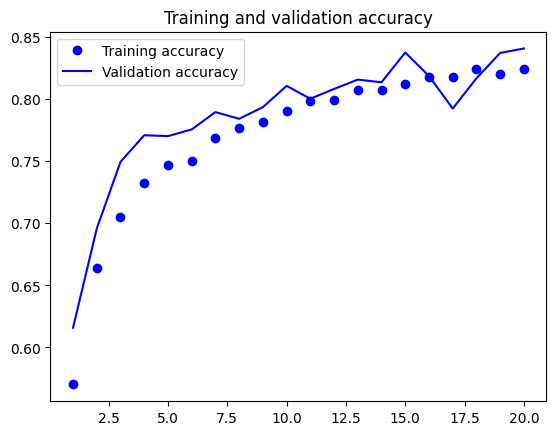

In [54]:
import matplotlib.pyplot as plt

history = fitCV.history
epochs = range(1, len(history['accuracy']) + 1)

plt.plot(epochs, history['accuracy'], 'bo', label='Training accuracy')
plt.plot(epochs, history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

In [ ]:
  # Use garbage collector for RAM and free up GPU 

    tf.keras.backend.clear_session()
    gc.collect()

IndexError: ignored

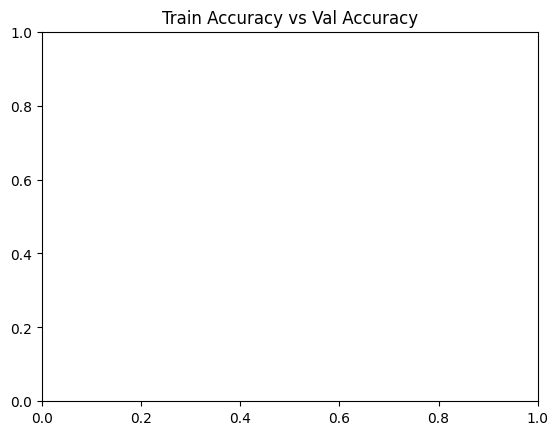

In [55]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_cv_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_cv_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")

plt.plot(model_cv_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_cv_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")

plt.plot(model_cv_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_cv_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")

plt.plot(model_cv_history[3].history['accuracy'], label='Train Accuracy Fold 4', color='blue', )
plt.plot(model_cv_history[3].history['val_accuracy'], label='Val Accuracy Fold 4', color='blue', linestyle = "dashdot")

plt.plot(model_cv_history[4].history['accuracy'], label='Train Accuracy Fold 5', color='orange', )
plt.plot(model_cv_history[4].history['val_accuracy'], label='Val Accuracy Fold 5', color='orange', linestyle = "dashdot")

plt.legend()
plt.show()

IndexError: ignored

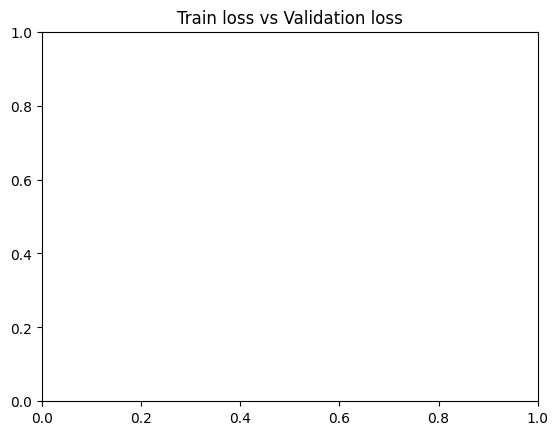

In [57]:
plt.title('Train loss vs Validation loss')
plt.plot(model_cv_history[5].history['loss'], label='Train loss Fold 1', color='black')
plt.plot(model_cv_history[5].history['val_loss'], label='Val loss Fold 1', color='black', linestyle = "dashdot")

plt.plot(model_cv_history[1].history['loss'], label='Train loss Fold 2', color='red', )
plt.plot(model_cv_history[1].history['val_loss'], label='Val loss Fold 2', color='red', linestyle = "dashdot")

plt.plot(model_cv_history[2].history['loss'], label='Train loss Fold 3', color='green', )
plt.plot(model_cv_history[2].history['val_loss'], label='Val loss Fold 3', color='green', linestyle = "dashdot")

plt.plot(model_cv_history[3].history['loss'], label='Train loss Fold 4', color='blue', )
plt.plot(model_cv_history[3].history['val_loss'], label='Val loss Fold 4', color='blue', linestyle = "dashdot")

plt.plot(model_cv_history[4].history['loss'], label='Train loss Fold 5', color='orange', )
plt.plot(model_cv_history[4].history['val_loss'], label='Val loss Fold 5', color='orange', linestyle = "dashdot")

plt.legend()
plt.show()